In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
# (Corrected Code for Cell 2)

# Define the correct column names based on the dataset description
column_names = [
    'sequence_name', 'frame', 'label', 'HeightWidthRatio', 'MajorMinorRatio',
    'BoundingBoxOccupancy', 'MaxStdXZ', 'HHmaxRatio', 'H', 'D', 'P40'
]

# Define paths to the feature files
adls_path = '../data/extracted_features/urfall-cam0-adls.csv'
falls_path = '../data/extracted_features/urfall-cam0-falls.csv'

# Load the CSVs using our defined column names
df_adls = pd.read_csv(adls_path, header=None, names=column_names)
df_falls = pd.read_csv(falls_path, header=None, names=column_names)

# Combine them into one large DataFrame
df = pd.concat([df_adls, df_falls], ignore_index=True)

print("Data loaded with correct column names.")
print(f"Total samples (frames) in the dataset: {len(df)}")
df.head()

Data loaded with correct column names.
Total samples (frames) in the dataset: 11544


,sequence_name,frame,label,HeightWidthRatio,MajorMinorRatio,BoundingBoxOccupancy,MaxStdXZ,HHmaxRatio,H,D,P40
0,adl-01,6,-1,6.3214,8.2230,0.49455,140.7718,0.95720,1761.2471,927.3002,0.026112
1,adl-01,8,-1,3.6316,4.5713,0.60584,159.6548,0.77655,1428.8440,818.2913,0.075228
2,adl-01,9,-1,4.8158,5.5638,0.62698,138.9976,0.93626,1722.7250,908.9348,0.085550
3,adl-01,10,-1,4.5122,5.1677,0.59209,138.3854,0.93194,1714.7726,944.6872,0.045424
4,adl-01,11,-1,4.1333,4.7776,0.60872,140.1724,0.93203,1714.9402,923.3361,0.072031


In [5]:
# The dataset description says to ignore frames with label '0' (transitional)
df_filtered = df[df['label'] != 0].copy()

# Map the labels for binary classification:
# -1 (not lying) -> 0
#  1 (lying/fall) -> 1
df_filtered['label'] = df_filtered['label'].map({-1: 0, 1: 1})

# Define the feature columns we want to use
feature_columns = [
    'HeightWidthRatio', 'MajorMinorRatio', 'BoundingBoxOccupancy',
    'MaxStdXZ', 'HHmaxRatio', 'H', 'D', 'P40'
]

# Separate features (X) and the target label (y)
X = df_filtered[feature_columns]
y = df_filtered['label']

print("Data prepared for modeling:")
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nClass distribution:")
print(y.value_counts())

Data prepared for modeling:
Features (X) shape: (9825, 8)
Target (y) shape: (9825,)

Class distribution:
label
0    7452
1    2373
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # Use 20% of data for testing
    random_state=42,      # Ensures the split is the same every time
    stratify=y            # Important for imbalanced datasets
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 7860
Testing set size: 1965


In [7]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
print("Training the Random Forest model...")
model.fit(X_train, y_train)
print("Training complete.")

Training the Random Forest model...
Training complete.


--- Classification Report ---
                precision    recall  f1-score   support

 Not Lying (0)       1.00      1.00      1.00      1490
Lying/Fall (1)       1.00      1.00      1.00       475

      accuracy                           1.00      1965
     macro avg       1.00      1.00      1.00      1965
  weighted avg       1.00      1.00      1.00      1965


--- Confusion Matrix ---


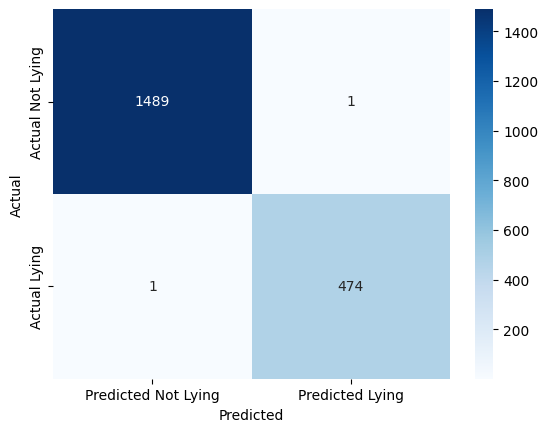

In [8]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# --- Generate the Classification Report ---
# This report gives us precision, recall, and f1-score
print("--- Classification Report ---")
# '0' is 'Not Lying', '1' is 'Lying/Fall'
print(classification_report(y_test, y_pred, target_names=['Not Lying (0)', 'Lying/Fall (1)']))


# --- Generate the Confusion Matrix ---
# This shows us exactly where the model made mistakes
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Not Lying', 'Predicted Lying'], 
            yticklabels=['Actual Not Lying', 'Actual Lying'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()